In [23]:
import numpy as np
import pandas as pd
from datetime import date, time, datetime, timedelta
from matplotlib import pyplot
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_validate

from sklearn import tree
import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

import xgboost as xgb

import graphviz
plt.rcParams["figure.figsize"] = (10,12)

In [2]:
weather=pd.read_csv('../data/weather.csv')
weather['date_time'] = pd.to_datetime(weather['date_time'])
weather.set_index("date_time", inplace=True)
weather.head()

,max_temp,min_temp,precip
date_time,,,
2018-01-01 00:00:00,14.4,14.150,0.0
2018-01-01 01:00:00,14.4,14.275,0.0
2018-01-01 02:00:00,14.4,14.400,0.0
2018-01-01 03:00:00,14.4,14.400,0.0
2018-01-01 04:00:00,14.4,13.900,0.0


In [3]:
df_la=pd.read_csv('../data/LA.csv')
df_la["start_time"] = pd.to_datetime(df_la['start_time'])
df_la["end_time"] = pd.to_datetime(df_la['end_time'] ) 
df_la["trip_duration"] = pd.to_timedelta(df_la.trip_duration)
df_la.set_index("start_time", inplace=True)
df_la.head()

,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,trip_duration,trip_duration_in_hours
start_time,,,,,,,,,
2018-01-01 00:04:00,2018-01-01 00:25:00,3063,3018,5889,Walk-up,Pershing Square,Grand & Olympic,0 days 00:21:00,0.350000
2018-01-01 00:05:00,2018-01-01 00:25:00,3063,3018,6311,Walk-up,Pershing Square,Grand & Olympic,0 days 00:20:00,0.333333
2018-01-01 00:06:00,2018-01-01 00:25:00,3063,3018,5753,Walk-up,Pershing Square,Grand & Olympic,0 days 00:19:00,0.316667
2018-01-01 00:13:00,2018-01-01 00:35:00,3018,3031,6220,Monthly Pass,Grand & Olympic,7th & Spring,0 days 00:22:00,0.366667
2018-01-01 00:14:00,2018-01-01 00:59:00,4204,4216,12436,Monthly Pass,Washington & Abbot Kinney,17th St / SMC E Line Station,0 days 00:45:00,0.750000


# Predictive Analysis

## Feature Engineering

In [4]:
#use weather data
df = weather.copy()

# calc demand
df["demand"] = df_la.bike_id.resample("H").count()
df

,max_temp,min_temp,precip,demand
date_time,,,,
2018-01-01 00:00:00,14.4,14.150,0.0,25
2018-01-01 01:00:00,14.4,14.275,0.0,24
2018-01-01 02:00:00,14.4,14.400,0.0,12
2018-01-01 03:00:00,14.4,14.400,0.0,3
2018-01-01 04:00:00,14.4,13.900,0.0,4
...,...,...,...,...
2018-12-31 19:00:00,16.7,16.700,0.0,13
2018-12-31 20:00:00,17.8,17.800,0.0,17
2018-12-31 21:00:00,16.7,16.700,0.0,26


In [5]:
# time, date features

#season 
df["season"] = df.index.month%12 // 3 + 1 
dummies = pd.get_dummies(df["season"]).rename(columns=lambda x: "season_" + str(x))
df = pd.concat([df, dummies], axis=1)
df.drop(["season"], inplace=True, axis=1)

#weekend or not
df["day_of_week"] = df.index.day_of_week
df["weekend"] = df.day_of_week.apply(lambda x: 1 if x >=4 else 0) #friday till sunday
df.drop("day_of_week", inplace=True, axis=1)

#time of wad
df["hour"] = df.index.hour 
df["time_of_day"] = df.hour.apply(lambda x: (x-1)//6 if x>0 else 3)
dummies = pd.get_dummies(df["time_of_day"]).rename(columns=lambda x: "time_of_day_" + str(x))
df = pd.concat([df, dummies], axis=1)
df.drop(["time_of_day"], inplace=True, axis=1)
df.drop(["hour"], inplace=True, axis=1)

df

,max_temp,min_temp,precip,demand,season_1,season_2,season_3,season_4,weekend,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3
date_time,,,,,,,,,,,,,
2018-01-01 00:00:00,14.4,14.150,0.0,25,1,0,0,0,0,0,0,0,1
2018-01-01 01:00:00,14.4,14.275,0.0,24,1,0,0,0,0,1,0,0,0
2018-01-01 02:00:00,14.4,14.400,0.0,12,1,0,0,0,0,1,0,0,0
2018-01-01 03:00:00,14.4,14.400,0.0,3,1,0,0,0,0,1,0,0,0
2018-01-01 04:00:00,14.4,13.900,0.0,4,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,16.7,16.700,0.0,13,1,0,0,0,0,0,0,0,1
2018-12-31 20:00:00,17.8,17.800,0.0,17,1,0,0,0,0,0,0,0,1
2018-12-31 21:00:00,16.7,16.700,0.0,26,1,0,0,0,0,0,0,0,1


In [6]:
#interaction features: time of day x weekend

df["time_of_day_0_x_weekend"] = df.time_of_day_0 * df.weekend
df["time_of_day_1_x_weekend"] = df.time_of_day_1 * df.weekend
df["time_of_day_2_x_weekend"] = df.time_of_day_2 * df.weekend
df["time_of_day_3_x_weekend"] = df.time_of_day_3 * df.weekend

df["time_of_day_0_x_not_weekend"] = df.time_of_day_0 * (1-df.weekend)
df["time_of_day_1_x_not_weekend"] = df.time_of_day_1 * (1-df.weekend)
df["time_of_day_2_x_not_weekend"] = df.time_of_day_2 * (1-df.weekend)
df["time_of_day_3_x_not_weekend"] = df.time_of_day_3 * (1-df.weekend)

df.drop(["time_of_day_0","time_of_day_1","time_of_day_2","time_of_day_3"], inplace=True, axis=1)

df

,max_temp,min_temp,precip,demand,season_1,season_2,season_3,season_4,weekend,time_of_day_0_x_weekend,time_of_day_1_x_weekend,time_of_day_2_x_weekend,time_of_day_3_x_weekend,time_of_day_0_x_not_weekend,time_of_day_1_x_not_weekend,time_of_day_2_x_not_weekend,time_of_day_3_x_not_weekend
date_time,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,14.4,14.150,0.0,25,1,0,0,0,0,0,0,0,0,0,0,0,1
2018-01-01 01:00:00,14.4,14.275,0.0,24,1,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-01 02:00:00,14.4,14.400,0.0,12,1,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-01 03:00:00,14.4,14.400,0.0,3,1,0,0,0,0,0,0,0,0,1,0,0,0
2018-01-01 04:00:00,14.4,13.900,0.0,4,1,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,16.7,16.700,0.0,13,1,0,0,0,0,0,0,0,0,0,0,0,1
2018-12-31 20:00:00,17.8,17.800,0.0,17,1,0,0,0,0,0,0,0,0,0,0,0,1
2018-12-31 21:00:00,16.7,16.700,0.0,26,1,0,0,0,0,0,0,0,0,0,0,0,1


In [7]:
#special days: metro event
df['event'] = 0
df.loc['2018-04-22 08:00:00':'2018-04-22 15:00:00','event'] = 1
df.loc['2018-09-30 08:00:00':'2018-09-30 15:00:00','event'] = 1
df.loc['2018-12-02 09:00:00':'2018-12-02 15:00:00','event'] = 1

df

,max_temp,min_temp,precip,demand,season_1,season_2,season_3,season_4,weekend,time_of_day_0_x_weekend,time_of_day_1_x_weekend,time_of_day_2_x_weekend,time_of_day_3_x_weekend,time_of_day_0_x_not_weekend,time_of_day_1_x_not_weekend,time_of_day_2_x_not_weekend,time_of_day_3_x_not_weekend,event
date_time,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,14.4,14.150,0.0,25,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2018-01-01 01:00:00,14.4,14.275,0.0,24,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2018-01-01 02:00:00,14.4,14.400,0.0,12,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2018-01-01 03:00:00,14.4,14.400,0.0,3,1,0,0,0,0,0,0,0,0,1,0,0,0,0
2018-01-01 04:00:00,14.4,13.900,0.0,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,16.7,16.700,0.0,13,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2018-12-31 20:00:00,17.8,17.800,0.0,17,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2018-12-31 21:00:00,16.7,16.700,0.0,26,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [8]:
#past demand

#lag features
df["lag_2"] = df.demand.shift(2)
df["lag_3"] = df.demand.shift(3)
df["lag_4"] = df.demand.shift(4)

df["lag_22"] = df.demand.shift(22)
df["lag_23"] = df.demand.shift(23)
df["lag_24"] = df.demand.shift(24) 

#rolling average 
df["rolling_avg"] = df.lag_2.rolling(22).mean()

df.dropna(inplace=True)
df

,max_temp,min_temp,precip,demand,season_1,season_2,season_3,season_4,weekend,time_of_day_0_x_weekend,...,time_of_day_2_x_not_weekend,time_of_day_3_x_not_weekend,event,lag_2,lag_3,lag_4,lag_22,lag_23,lag_24,rolling_avg
date_time,,,,,,,,,,,,,,,,,,,,,
2018-01-02 00:00:00,16.1,16.1,0.0,6,1,0,0,0,0,0,...,0,1,0,4.0,11.0,29.0,12.0,24.0,25.0,32.818182
2018-01-02 01:00:00,15.6,15.6,0.0,7,1,0,0,0,0,0,...,0,0,0,10.0,4.0,11.0,3.0,12.0,24.0,32.181818
2018-01-02 02:00:00,15.6,15.0,0.0,1,1,0,0,0,0,0,...,0,0,0,6.0,10.0,4.0,4.0,3.0,12.0,31.909091
2018-01-02 03:00:00,15.6,15.6,0.0,0,1,0,0,0,0,0,...,0,0,0,7.0,6.0,10.0,7.0,4.0,3.0,32.090909
2018-01-02 04:00:00,15.0,15.0,0.0,0,1,0,0,0,0,0,...,0,0,0,1.0,7.0,6.0,13.0,7.0,4.0,31.954545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00,16.7,16.7,0.0,13,1,0,0,0,0,0,...,0,1,0,36.0,61.0,67.0,9.0,19.0,26.0,24.045455
2018-12-31 20:00:00,17.8,17.8,0.0,17,1,0,0,0,0,0,...,0,1,0,25.0,36.0,61.0,4.0,9.0,19.0,24.318182
2018-12-31 21:00:00,16.7,16.7,0.0,26,1,0,0,0,0,0,...,0,1,0,13.0,25.0,36.0,8.0,4.0,9.0,24.500000


<AxesSubplot:>

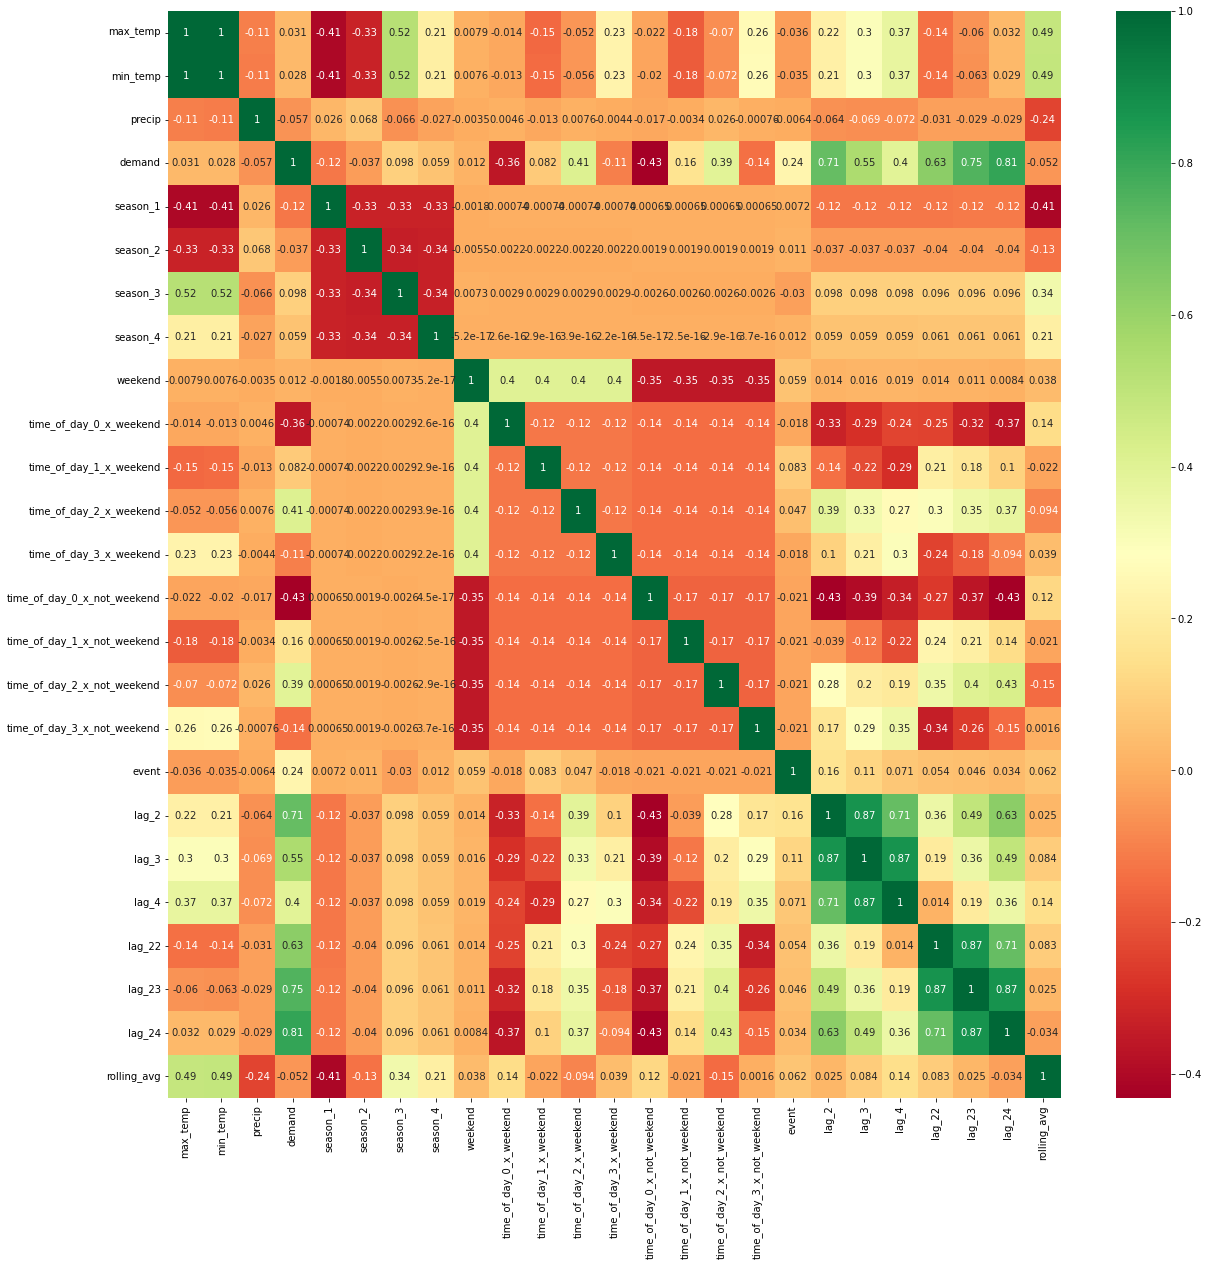

In [9]:
#test feature correlation with demand
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))

#plot heat map
sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Model Building

In [10]:
X = df.drop(["demand"],axis=1).copy()
y = df.demand

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
# find best hyperparameters with Grid Search
def find_params(param_grid, model, X_train, y_train):
    
    grid = GridSearchCV(estimator = model, param_grid = param_grid)
    grid.fit(X_train, y_train)
    
    print("score: ", grid.best_score_)
    print("best parameters: ",grid.best_params_)
    return grid

### Random Forest

In [12]:
model = RandomForestRegressor(random_state = 42)
param_grid = {'min_samples_split' : [2, 3, 4, 5],
                    'min_samples_leaf' : [1, 2, 3]
           }
params1 = find_params(param_grid, model, X_train, y_train).best_params_

model = RandomForestRegressor(random_state = 42, **params1)
param_grid = {'ccp_alpha': [0.001, 0.005, 0.01, 0.05]
           }
params2 = {**params1, **(find_params(param_grid, model, X_train, y_train).best_params_)}

model = RandomForestRegressor(random_state = 42, **params2)
param_grid = {'n_estimators': [300, 350, 400, 450, 500, 550, 600]
           }

RFR = find_params(param_grid, model, X_train, y_train)

score:  0.8446711454270359
best parameters:  {'min_samples_leaf': 1, 'min_samples_split': 4}
score:  0.8446872640861105
best parameters:  {'ccp_alpha': 0.005}
score:  0.8463519265374921
best parameters:  {'n_estimators': 550}


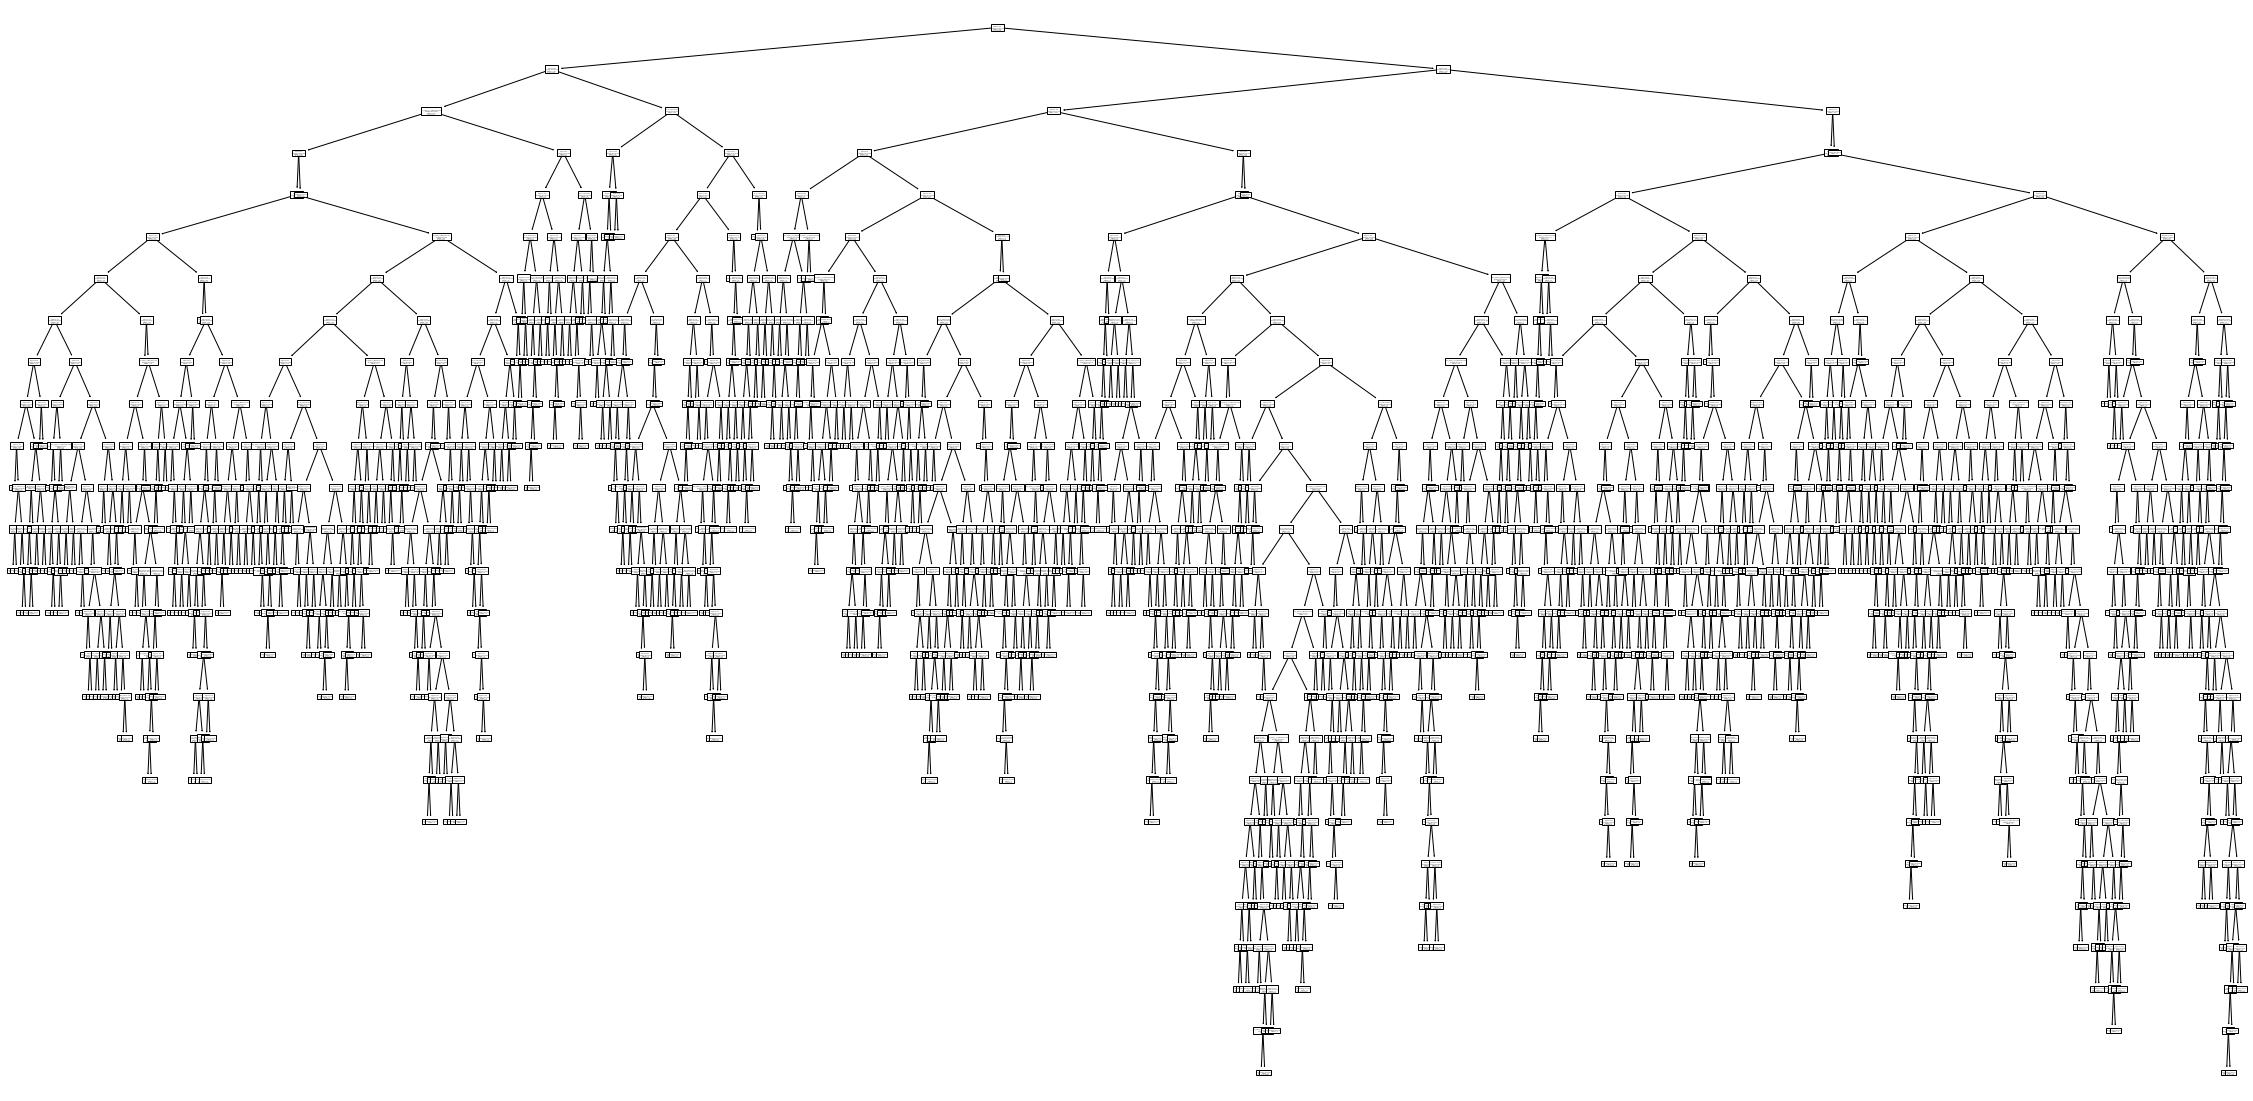

In [13]:
plt.figure(figsize=(40,20))
tree.plot_tree(RFR.best_estimator_.estimators_[0], feature_names = X.columns)
RFR.best_estimator_.feature_importances_ #todo names. sort. print
plt.show()

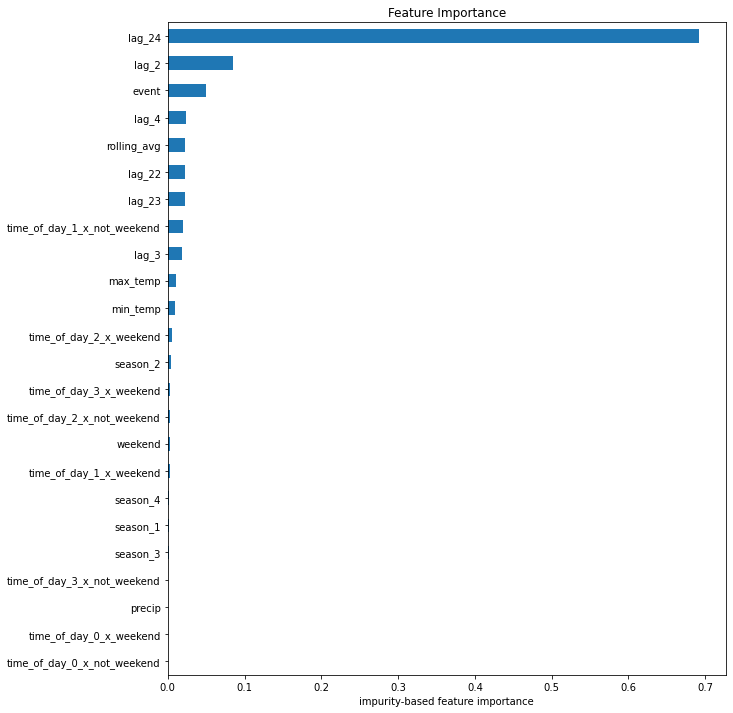

In [14]:
feat_importances = pd.Series(RFR.best_estimator_.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.xlabel("impurity-based feature importance")

plt.show()

### XGBoost

In [15]:
model = xgb.XGBRegressor(random_state=42)
param_grid = {
 'max_depth': [2,3,4,5,6],
 'min_child_weight': [0,0.001,0.01],
}
params1 = find_params(param_grid,model,X_train,y_train).best_params_

model = xgb.XGBRegressor(random_state=42, **params1)
param_grid = {
 'gamma': [0.0, 0.001, 0.005, 0.01],
 'subsample': [0.8, 0.85, 0.9, 0.95, 1],
}
params2 = {**params1, **(find_params(param_grid,model,X_train,y_train).best_params_)}

model = xgb.XGBRegressor(random_state=42, **params2)
param_grid = {
 'colsample_bytree': [0.85, 0.9, 0.95, 1],
 'reg_alpha': [0.005, 0.01, 0.05, 0.1, 0.5, 1],
}
params3 = {**params2, **(find_params(param_grid,model,X_train,y_train).best_params_)}

model = xgb.XGBRegressor(random_state=42, **params3)
param_grid = {
    'n_estimators': [25, 50, 75, 100, 125, 150]
}

XGB = find_params(param_grid, model, X_train, y_train)

score:  0.8424568742616394
best parameters:  {'max_depth': 5, 'min_child_weight': 0}
score:  0.8424568742616394
best parameters:  {'gamma': 0.0, 'subsample': 1}
score:  0.8466774737026718
best parameters:  {'colsample_bytree': 0.95, 'reg_alpha': 0.01}
score:  0.8492489249420135
best parameters:  {'n_estimators': 50}


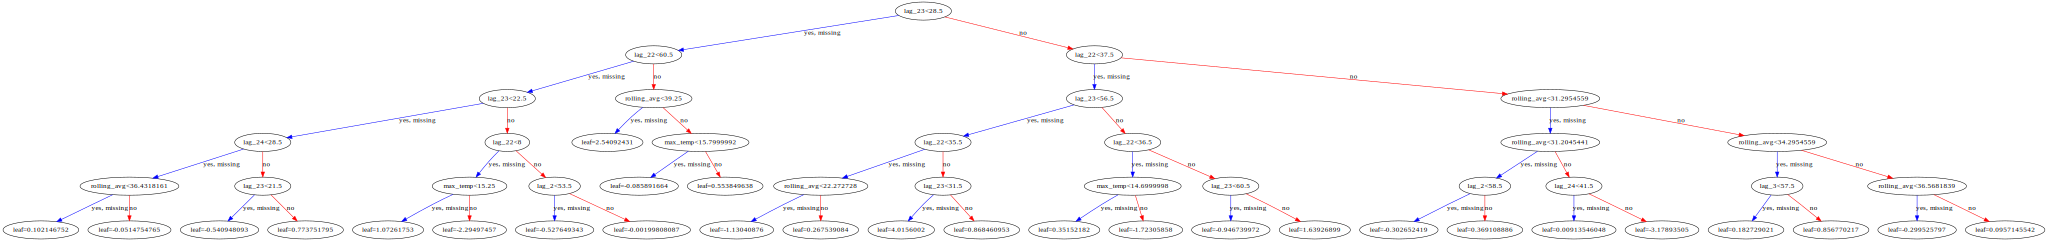

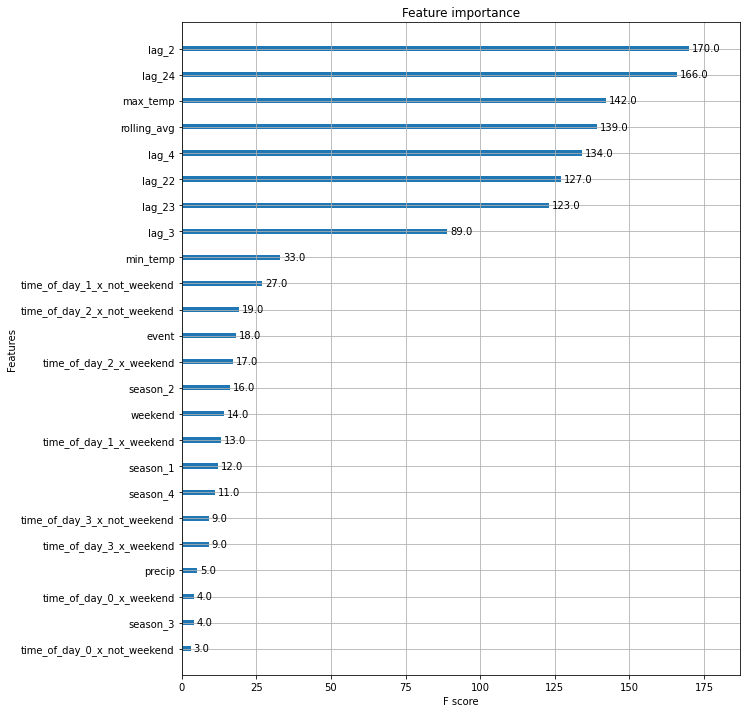

In [16]:
xgb.plot_importance(XGB.best_estimator_)
xgb.to_graphviz(XGB.best_estimator_, num_trees=XGB.best_estimator_.best_iteration)

## Polynomial Regression

In [17]:
#top 10 features
df_selected = df[['lag_2', 'lag_24', 'max_temp', 'rolling_avg', 'lag_4', 'lag_22', 'lag_23', 'lag_3', 'min_temp', 'time_of_day_1_x_not_weekend', 'demand']]

#top 3 features
#df_selected = df_selected[['lag_2', 'lag_24', 'max_temp', 'demand']] 
#df_selected.head(2)

X = df_selected.drop(["demand"],axis=1).copy()
y = df_selected.demand

#split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

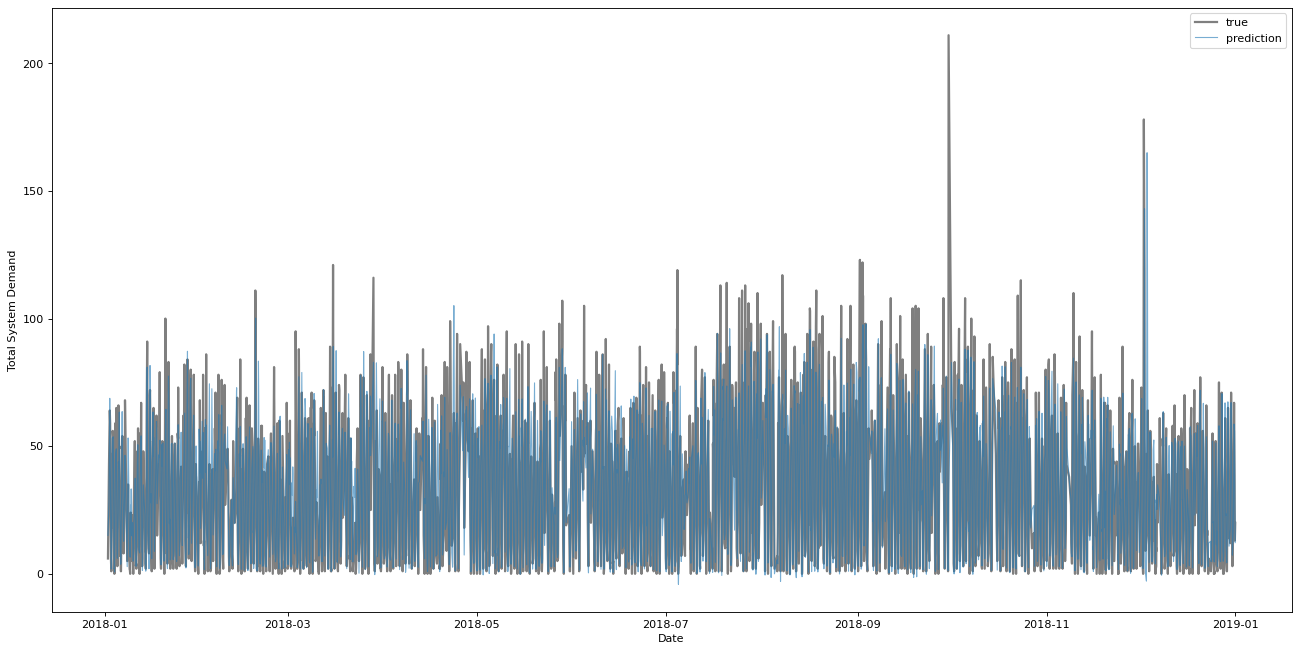

R^2 score: 0.7657805391792882
Mean Absolute Error: 9.236029853581416
Root Mean Squared Error: 13.794529785265354
Average Error: -0.2632424559491475


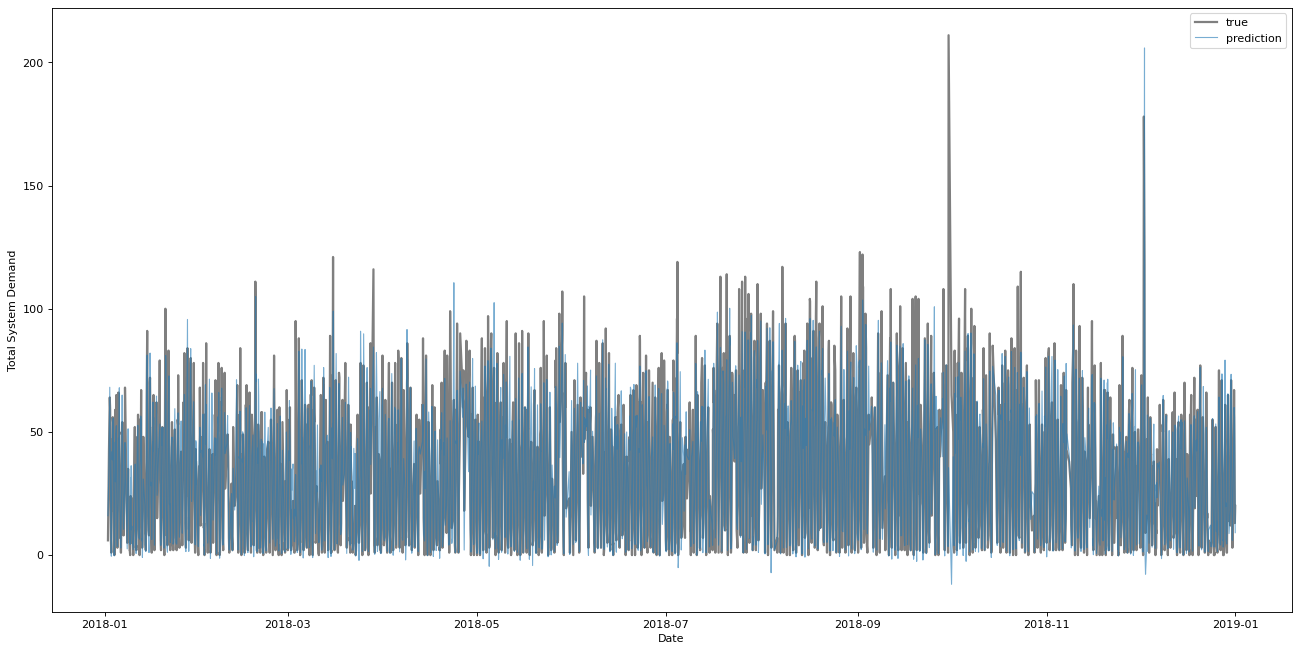

R^2 score: 0.7936125262629712
Mean Absolute Error: 8.650575103707245
Root Mean Squared Error: 12.949025329284169
Average Error: -0.08202339835899378


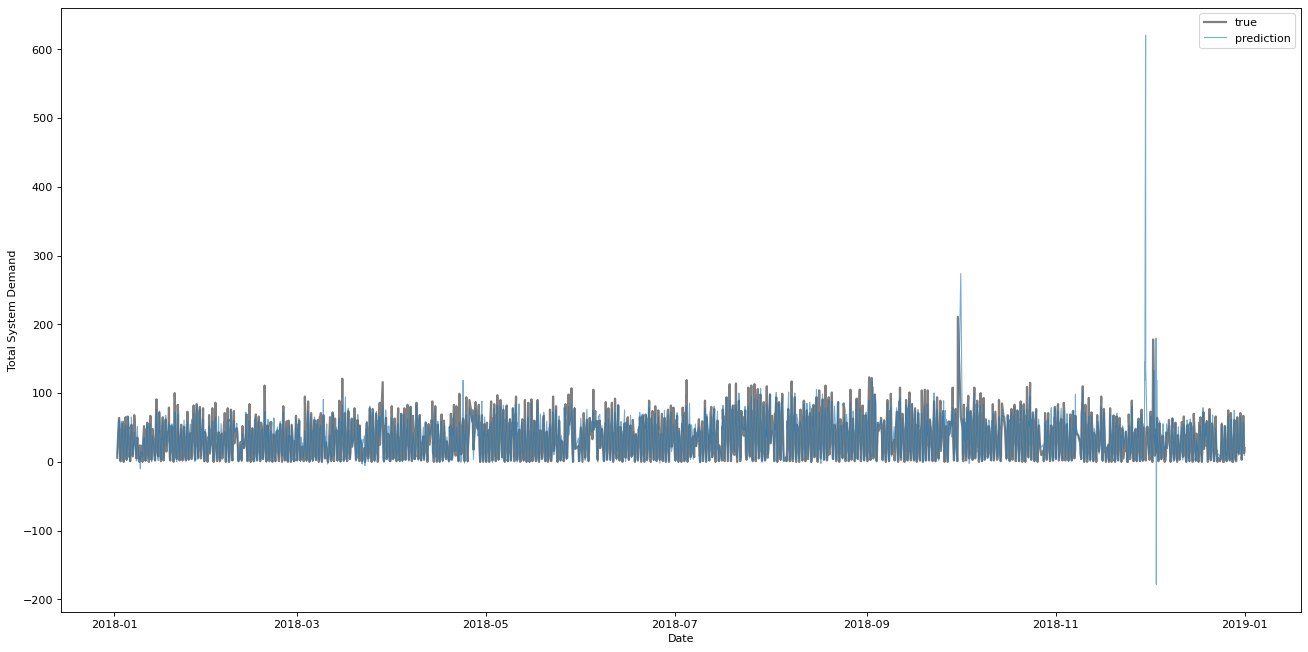

R^2 score: 0.5620468743893592
Mean Absolute Error: 8.749328397373018
Root Mean Squared Error: 18.8629332495408
Average Error: -0.32345844307534605


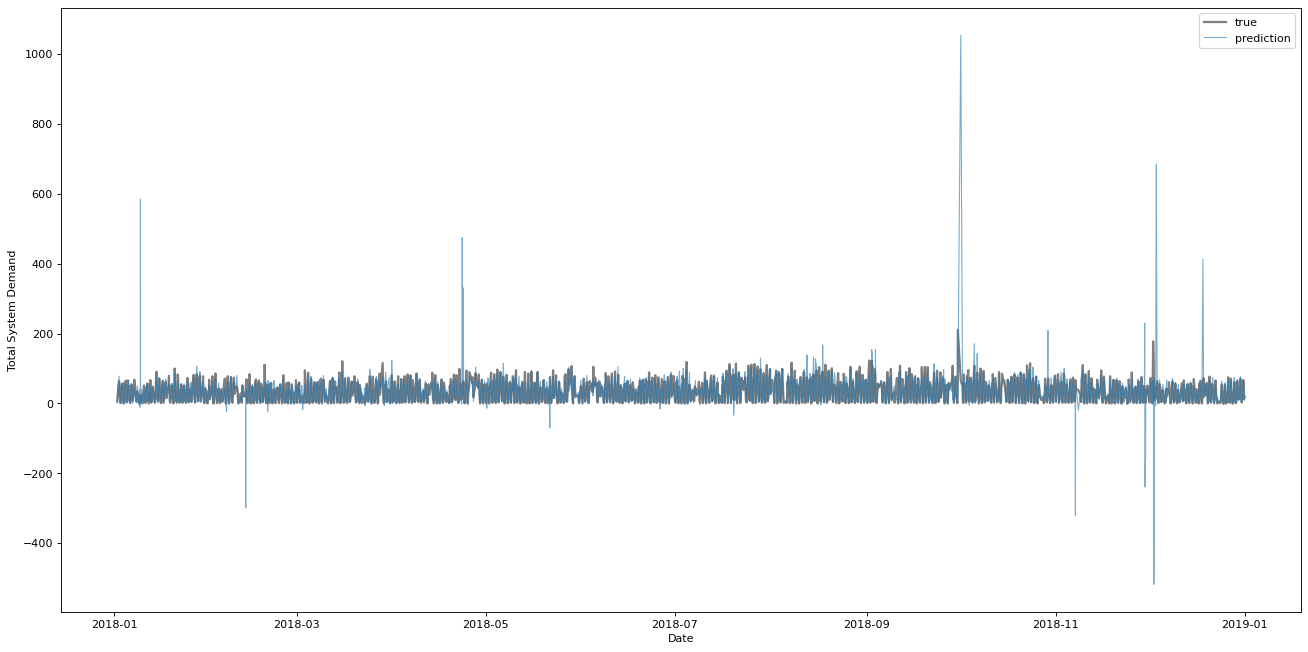

R^2 score: -0.7586037934634906
Mean Absolute Error: 11.563344771433
Root Mean Squared Error: 37.798922122048545
Average Error: -0.7169734390191413


In [24]:
rmse_err_train = []
rmse_err_test = []
r2_err_train  = []
r2_err_test = []
mae_err_train  = []
mae_err_test = []
ae_err_train  = []
ae_err_test = []
deg = []
degree = 5

for i in range(1,degree,1):
    #"Creates a polynomial regression model for the given degree"
    poly_features = PolynomialFeatures(degree=i)

    # transforms the existing features to higher degree features.
    X_train_poly = poly_features.fit_transform(X_train)

    # fit the transformed features to Linear Regression
    poly_model = LinearRegression()
    poly_model.fit(X_train_poly, y_train)

    # predicting on training data-set
    y_train_predicted = poly_model.predict(X_train_poly)

    # predicting on test data-set
    y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
    
    # evaluating the model on training dataset
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
    r2_train = r2_score(y_train, y_train_predicted)
    mae_train = mean_absolute_error(y_train, y_train_predicted)
    ae_train = sum(y_train - y_train_predicted)/len(y_train_predicted)

    # evaluating the model on test dataset
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
    r2_test = r2_score(y_test, y_test_predict)
    mae_test = mean_absolute_error(y_test, y_test_predict)
    ae_test = sum(y_test - y_test_predict)/len(y_test_predict)
    
    # append train errors
    rmse_err_train.append(rmse_train)
    r2_err_train.append(r2_train)
    mae_err_train.append(mae_train)
    ae_err_train.append(ae_train)
    
    # append test errors
    rmse_err_test.append(rmse_test)
    r2_err_test.append(r2_test) 
    mae_err_test.append(mae_test)
    ae_err_test.append(ae_test) 
    
    deg.append(i)
    
    #plot all errors
    plot_true_vs_prediction(y_test_predict, y_test)

#     print("The model performance for the training set")  
#     print("-------------------------------------------")
#     print("RMSE of training set is {}".format(rmse_train))
#     print("R2 score of training set is {}".format(r2_train))

#     print("\n")

#     print("The model performance for the test set")
#     print("-------------------------------------------")
#     print("RMSE of test set is {}".format(rmse_test))
#     print("R2 score of test set is {}".format(r2_test))


## Polynomial Model (degree=2)

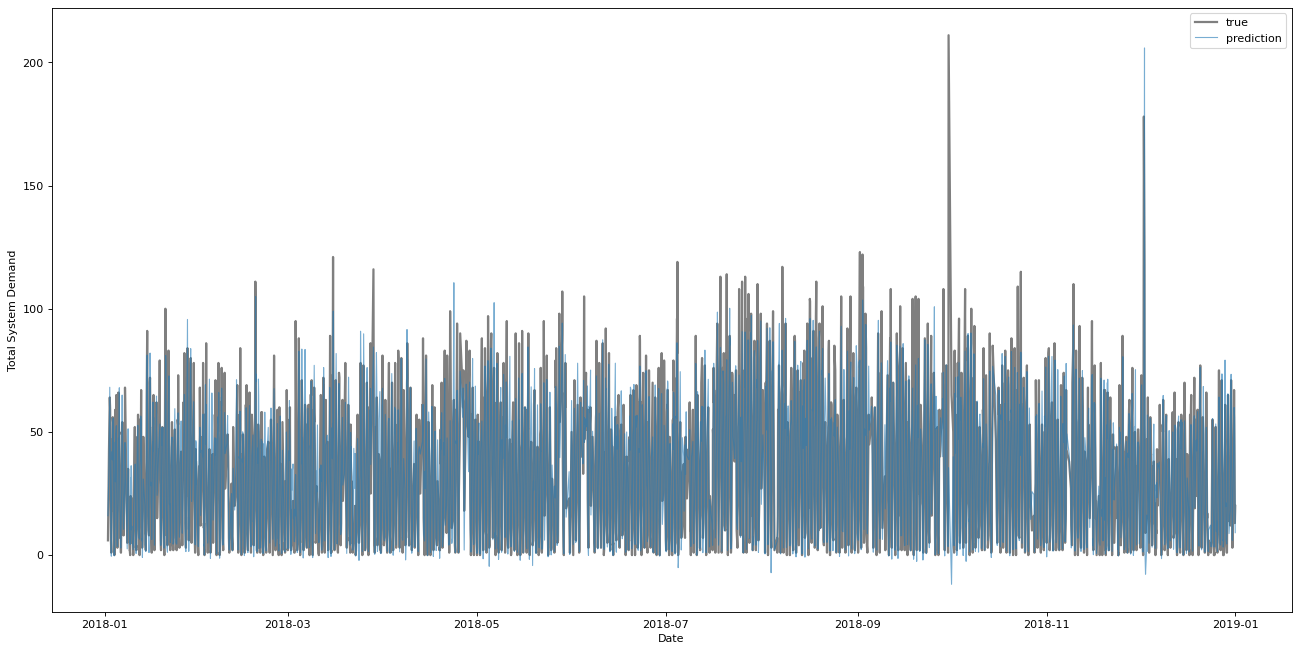

R^2 score: 0.7936125262629712
Mean Absolute Error: 8.650575103707245
Root Mean Squared Error: 12.949025329284169
Average Error: -0.08202339835899378


In [25]:
#"Creates a polynomial regression model for the given degree"
poly_features = PolynomialFeatures(degree=2)

# transforms the existing features to higher degree features.
X_train_poly = poly_features.fit_transform(X_train)

# fit the transformed features to Linear Regression
poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)

# predicting on training data-set
y_train_predicted = poly_model.predict(X_train_poly)

# predicting on test data-set
y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))

#Evaluating
plot_true_vs_prediction(y_test_predict, y_test)

## Model Evaluation

In [26]:
def plot_true_vs_prediction(y_pred,y_test):
    
    # create sorted series for true and predicted values
    y_pred_series = pd.Series(np.array(y_pred) ,index = y_test.index) 
    y_pred_series_sorted = y_pred_series.sort_index()
    y_test_sorted = y_test.sort_index()

    # plot true vs predicted values
    fig,ax = plt.subplots(figsize = (20, 10), dpi = 80) 
    ax.plot(y_test_sorted, label = "true", linewidth = 2, color = "tab:gray")
    ax.plot(y_pred_series_sorted, label = "prediction", linewidth = 1, alpha = 0.6, color = "tab:blue")
    ax.set_ylabel('Total System Demand')
    ax.set_xlabel('Date')
    ax.legend()
    plt.show()
    
    # evaluation metrics
    print("R^2 score:",r2_score(y_test,y_pred))
    print("Mean Absolute Error:",mean_absolute_error(y_test,y_pred))
    print("Root Mean Squared Error:",mean_squared_error(y_test,y_pred)**0.5)
    print("Average Error:", sum(y_test - y_pred)/len(y_pred))

### Random Forest

In [27]:
y_pred_RFR = RFR.predict(X_test)

plot_true_vs_prediction(y_pred_RFR, y_test)

C:\Users\Marc\anaconda3\envs\BananaCode\lib\site-packages\sklearn\base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- event
- precip
- season_1
- season_2
- season_3
- ...

  warnings.warn(message, FutureWarning)


ValueError: X has 10 features, but RandomForestRegressor is expecting 24 features as input.

### XGBoost

In [28]:
y_pred_XGB = XGB.predict(X_test)

plot_true_vs_prediction(y_pred_XGB, y_test)

ValueError: Feature shape mismatch, expected: 24, got 10

## Polynomial 

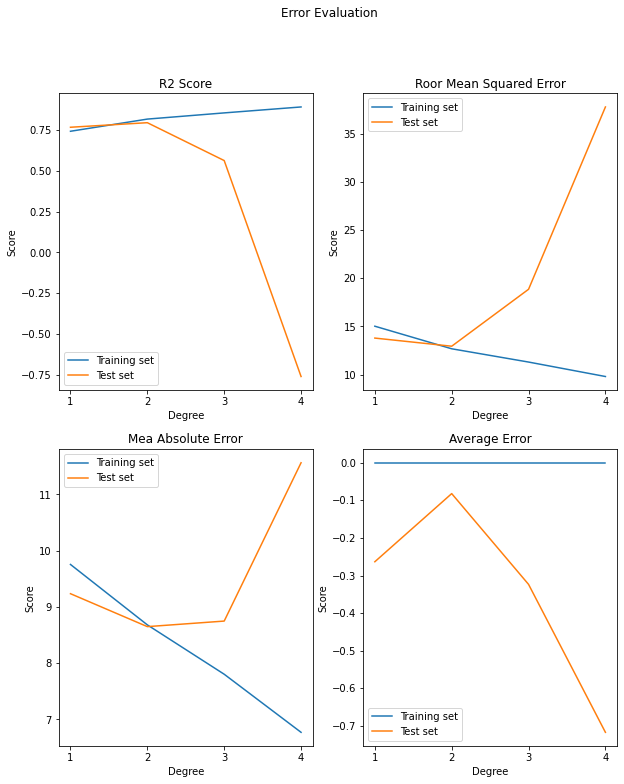

In [29]:
fig, axs = plt.subplots(nrows=2,ncols=2)
fig.suptitle('Error Evaluation')

#plot the R2 error
axs[0,0].plot(range(degree-1), r2_err_train, range(degree-1), r2_err_test)
axs[0,0].set_xlabel("Degree")
axs[0,0].set_title("R2 Score")
axs[0,0].set_xticks(np.arange(len(r2_err_train)), np.arange(1,len(r2_err_train)+1))
axs[0,0].set_ylabel("Score")
axs[0,0].legend(['Training set', 'Test set'])

#plot the RSME error
axs[0,1].plot(range(degree-1), rmse_err_train, range(degree-1), rmse_err_test)
axs[0,1].set_xlabel("Degree")
axs[0,1].set_title("Roor Mean Squared Error")
axs[0,1].set_xticks(np.arange(len(rmse_err_train)), np.arange(1,len(rmse_err_train)+1))
axs[0,1].set_ylabel("Score")
axs[0,1].legend(['Training set', 'Test set'])

#plot the MAE error
axs[1,0].plot(range(degree-1), mae_err_train, range(degree-1), mae_err_test)
axs[1,0].set_xlabel("Degree")
axs[1,0].set_title("Mea Absolute Error")
axs[1,0].set_xticks(np.arange(len(mae_err_train)), np.arange(1,len(mae_err_train)+1))
axs[1,0].set_ylabel("Score")
axs[1,0].legend(['Training set', 'Test set'])

#plot the AE error
axs[1,1].plot(range(degree-1), ae_err_train, range(degree-1), ae_err_test)
axs[1,1].set_xlabel("Degree")
axs[1,1].set_title("Average Error")
axs[1,1].set_xticks(np.arange(len(ae_err_train)), np.arange(1,len(ae_err_train)+1))
axs[1,1].set_ylabel("Score")
axs[1,1].legend(['Training set', 'Test set'])